# Project 2 - Part 1

## TODO

- visualize attention maps: Visualize the attention map learned by your model using input layer weights. Do you gain any insight on important data points to distinguish between normal and abnormal sequences (2 pts)?

- make more consistent (training function, dataloader etc.)

- save epoch_accuracies etc. in pickle

In [3]:
pip install -r requirements.txt

ERROR: Ignored the following versions that require a different python version: 8.19.0 Requires-Python >=3.10; 8.20.0 Requires-Python >=3.10; 8.21.0 Requires-Python >=3.10; 8.22.0 Requires-Python >=3.10; 8.22.1 Requires-Python >=3.10; 8.22.2 Requires-Python >=3.10; 8.23.0 Requires-Python >=3.10; 8.24.0 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement ipython==8.24.0 (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import math
import pickle
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

## Exploratory Data Analysis

In [2]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']

X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

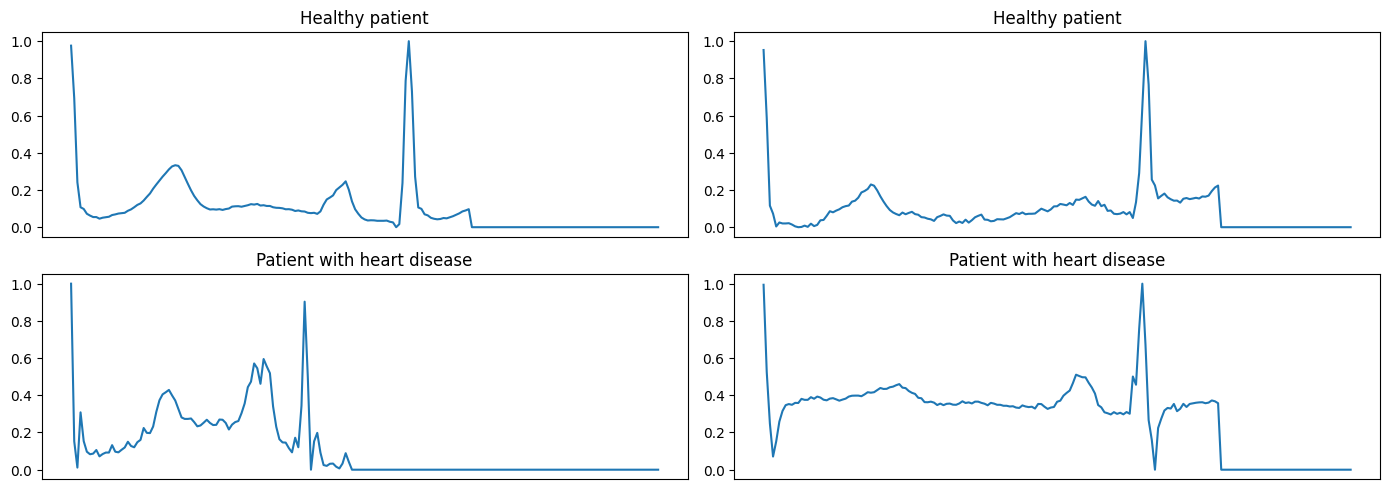

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

# Flatten the array for easy iteration
axs = axs.flatten()

healthy_patients = X_train.loc[y_train == 0]
diagnosed_patients = X_train.loc[y_train == 1]

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    if i < 2:
        axs[i].plot(healthy_patients.iloc[i % 2])
        axs[i].set_title('Healthy patient')
    else:
        axs[i].plot(diagnosed_patients.iloc[i % 2])
        axs[i].set_title('Patient with heart disease')
    
    # Set x ticks in 3 equidistant positions
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

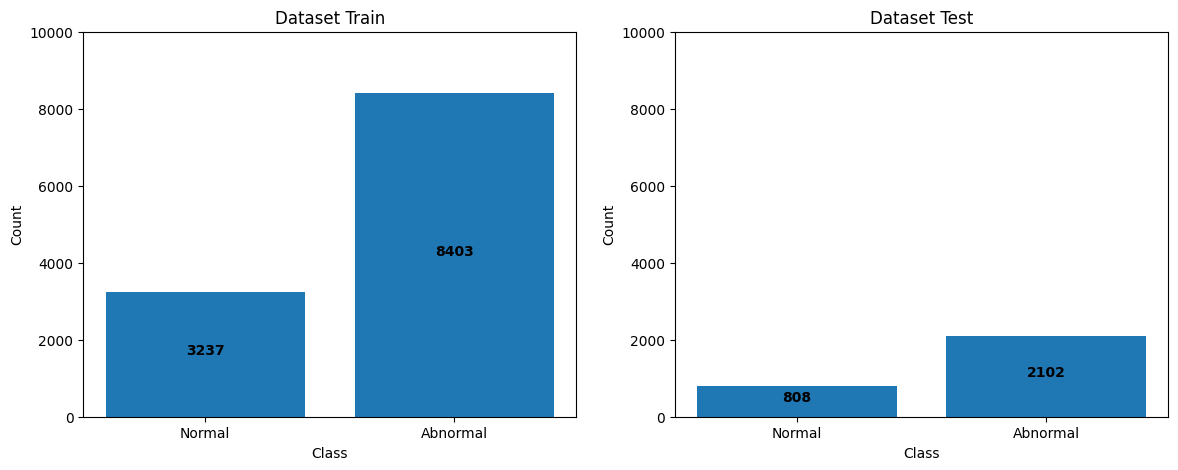

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(['Normal', 'Abnormal'], datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
    axs[i].set_ylim((0,10000))
plt.show()


In [5]:
n = len(y_train) + len(y_test)
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(len(datasets[i])/n*100) + '%')

Dataset Train: 80.0%
Dataset Test: 20.0%


In [6]:
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(np.mean(datasets[i])*100) + '%')

Dataset Train: 72.19072164948453%
Dataset Test: 72.23367697594502%


## Classic Machine Learning Methods

### Logistic Regression

In [7]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Train accuracy: ' + str(log_reg.score(X_train, y_train)))
print('Test accuracy: ' + str(log_reg.score(X_test, y_test)))

Train accuracy: 0.8344501718213059
Test accuracy: 0.8223367697594501


### Random Forest

In [8]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Train accuracy: ' + str(rf.score(X_train, y_train)))
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9676975945017182


### Feature Design

In [10]:
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

X_train_extended['mean'] = X_train.mean(axis=1)
X_train_extended['std'] = X_train.std(axis=1)
X_train_extended['median'] = X_train.median(axis=1)
X_train_extended['max'] = X_train.max(axis=1)
X_train_extended['min'] = X_train.min(axis=1)
X_train_extended['range'] = X_train.max(axis=1) - X_train.min(axis=1)
X_train_extended['iqr'] = X_train.quantile(0.75, axis=1) - X_train.quantile(0.25, axis=1)
X_train_extended['q1'] = X_train.quantile(0.25, axis=1)
X_train_extended['q3'] = X_train.quantile(0.75, axis=1)
X_train_extended['kurtosis'] = X_train.kurtosis(axis=1)
X_train_extended['skew'] = X_train.skew(axis=1)
X_test_extended['mean'] = X_test.mean(axis=1)
X_test_extended['std'] = X_test.std(axis=1)
X_test_extended['median'] = X_test.median(axis=1)
X_test_extended['max'] = X_test.max(axis=1)
X_test_extended['min'] = X_test.min(axis=1)
X_test_extended['range'] = X_test.max(axis=1) - X_test.min(axis=1)
X_test_extended['iqr'] = X_test.quantile(0.75, axis=1) - X_test.quantile(0.25, axis=1)
X_test_extended['q1'] = X_test.quantile(0.25, axis=1)
X_test_extended['q3'] = X_test.quantile(0.75, axis=1)
X_test_extended['kurtosis'] = X_test.kurtosis(axis=1)
X_test_extended['skew'] = X_test.skew(axis=1)

In [11]:
log_reg_extended = LogisticRegression(max_iter=1000)
log_reg_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(log_reg_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(log_reg_extended.score(X_test_extended, y_test)))

Train accuracy: 0.8384020618556701
Test accuracy: 0.8340206185567011


In [12]:
rf_extended = RandomForestClassifier()
rf_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(rf_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(rf_extended.score(X_test_extended, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9690721649484536


## Recurrent Neural Networks - LSTM

### Unidirectional LSTM


In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [6]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Balance training data
X_train_tensor = torch.cat([X_train_tensor[y_train == 0], X_train_tensor[y_train == 1][:len(y_train[y_train == 0])]])
y_train_tensor = torch.cat([y_train_tensor[y_train == 0], y_train_tensor[y_train == 1][:len(y_train[y_train == 0])]])

X_train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=100, shuffle=True)
X_test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=100, shuffle=False)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=True, bidirectional=bidirectional)
        
        _hidden_size = hidden_size if not bidirectional else hidden_size * 2
        self.fc1 = torch.nn.Linear(_hidden_size * num_layers, hidden_size * num_layers)
        self.fc2 = torch.nn.Linear(hidden_size * num_layers, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                # Initialize weights with Xavier initialization
                init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zeros
                init.constant_(param, 0.0)
        
    def forward(self, x):
        _, (hidden,_) = self.lstm(x)
        out = self.fc1(hidden.permute(1,0,2).flatten(start_dim=1))
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [25]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []
    
    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        true_train = []
        pred_train = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]
            
            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)
                
            loss = criterion(outputs, y_batch)
            pred_train.append((outputs > 0.5).int())
            true_train.append(y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        epoch_accuracies_training.append(balanced_accuracy_score(torch.cat(true_train).int().cpu().numpy(), torch.cat(pred_train).cpu().numpy()))
        epoch_losses_training.append(total_loss/len(X_train_tensor))

        with torch.no_grad():
            pred_test = []
            true_test = []
            total_loss_test = 0
            for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
                if truncate:
                    max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                    X_batch = X_batch[:, :max_seq_len, :]
                
                if ret_weights:
                    outputs, _ = model(X_batch)
                else:
                    outputs = model(X_batch)
                    
                loss = criterion(outputs, y_batch)
                pred_test.append((outputs > 0.5).int())
                true_test.append(y_batch)

                total_loss_test += loss.item() * len(X_batch)

            epoch_accuracies_testing.append(balanced_accuracy_score(torch.cat(true_test).int().cpu().numpy(), torch.cat(pred_test).cpu().numpy()))
            epoch_losses_testing.append(total_loss_test/len(X_test_tensor))

            pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')
        
    with open(f'./p1/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
        pickle.dump((epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing), f)

    torch.save(model.state_dict(), f'./p1/models/{model_name}_{num_epochs}.pth')

In [26]:
def plot_acc_and_loss(model_name, num_epochs):
    
    with open(f'./p1/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(f)
            except EOFError:
                break

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plotting the losses
    axs[0].plot(epoch_losses_training, label='Training Loss')
    axs[0].plot(epoch_losses_testing, label='Testing Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plotting the accuracies
    axs[1].plot(epoch_accuracies_training, label='Training Balanced Accuracy')
    axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [11]:
def print_model_summary(model, criterion, X_test_tensor, y_test_tensor, ret_weights=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    with torch.no_grad():
        if ret_weights:
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), outputs.cpu().numpy())}')

In [21]:
input_size = 1  
hidden_size = 50
num_layers = 5
output_size = 1

lstm = LSTMModel(input_size, hidden_size, num_layers, output_size, bidirectional=False).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=3e-5)

In [25]:
num_epochs = 400
torch.manual_seed(42)
model_name = 'lstm'

Epoch [400/400], Loss: 0.5547, Balanced Accuracy: 0.7011, Test Loss: 0.5335, Test Balanced Accuracy: 0.6909: 100%|██████████| 400/400 [33:22<00:00,  5.01s/it]


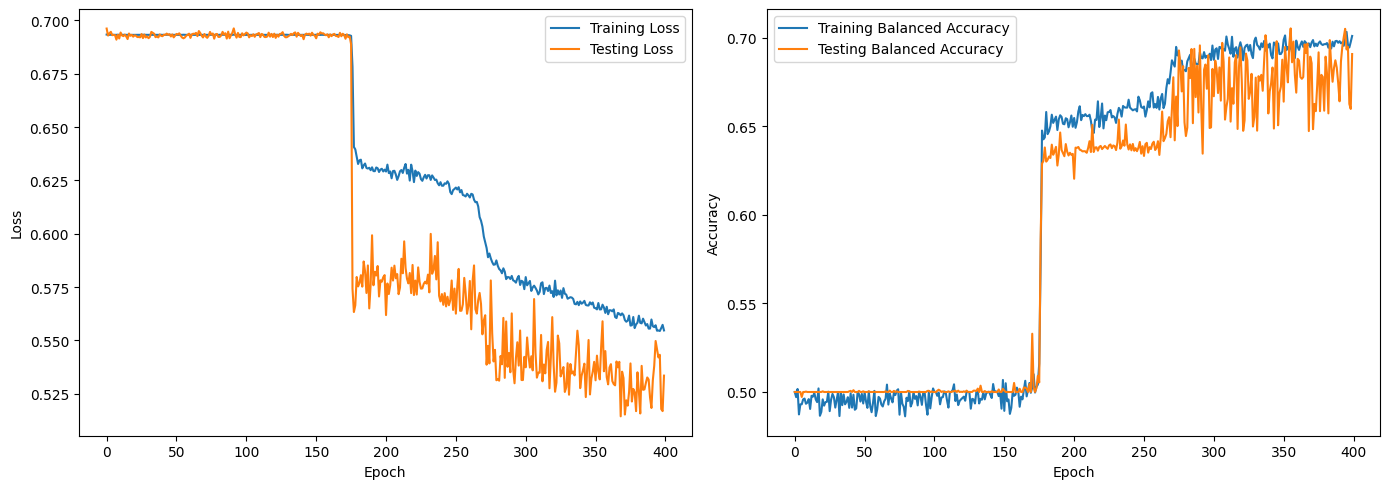

In [26]:
train_model(lstm, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=True)
plot_acc_and_loss(model_name, num_epochs)

In [2]:
lstm.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(lstm, criterion, X_test_tensor, y_test_tensor)

NameError: name 'lstm' is not defined

### Bidirectional LSTM


In [23]:
lstm_bidir = LSTMModel(input_size, hidden_size, num_layers, output_size, bidirectional=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_bidir.parameters(), lr=0.0005)

In [24]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'lstm_bidir'

Epoch [200/200], Training Loss: 0.0314, Training Accuracy: 0.9889, Test loss: 0.2051, Test Accuracy: 0.9589: 100%|██████████| 200/200 [19:19<00:00,  5.80s/it]


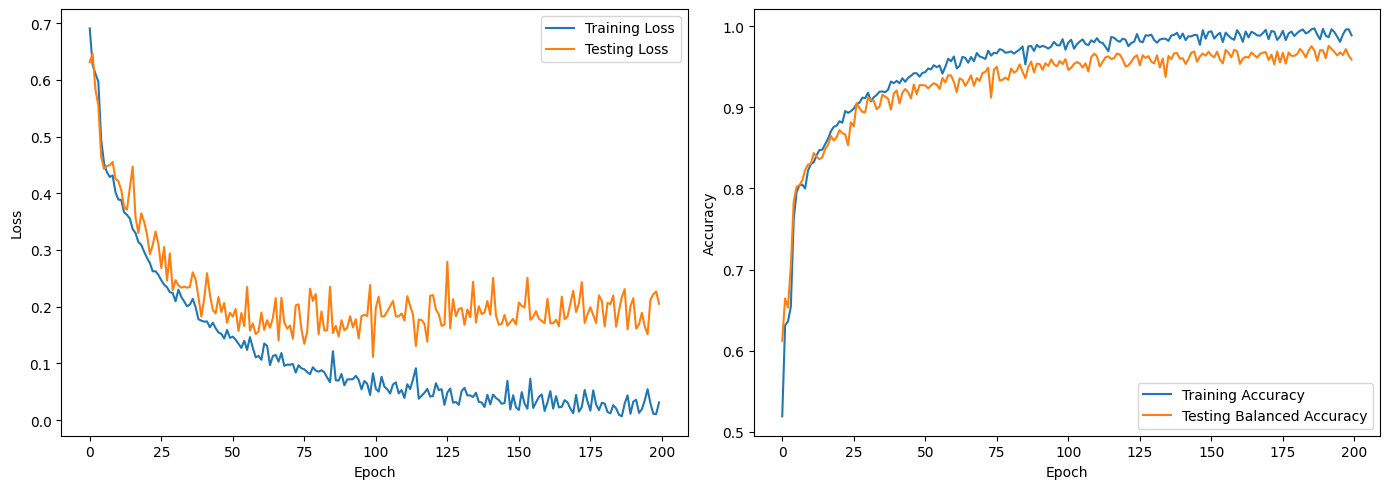

In [25]:
train_model(lstm_bidir, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=True)
plot_acc_and_loss(model_name, num_epochs)

In [26]:
lstm_bidir.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(lstm_bidir, criterion, X_test_tensor, y_test_tensor)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=5, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=500, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 389901
Accuracy: 0.9756, Loss: 0.1612, Balanced Accuracy: 0.9758734020404896


## Convolutional Neural Networks

### Vanilla CNN

In [27]:
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.LazyLinear(out_features = output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.squeeze(x, dim=-1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [28]:
input_size = X_train_tensor.shape[1]
output_size = 1

cnn = CNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [29]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'cnn'

Epoch [200/200], Training Loss: 0.0691, Training Accuracy: 0.9781, Test loss: 0.1996, Test Accuracy: 0.9499: 100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


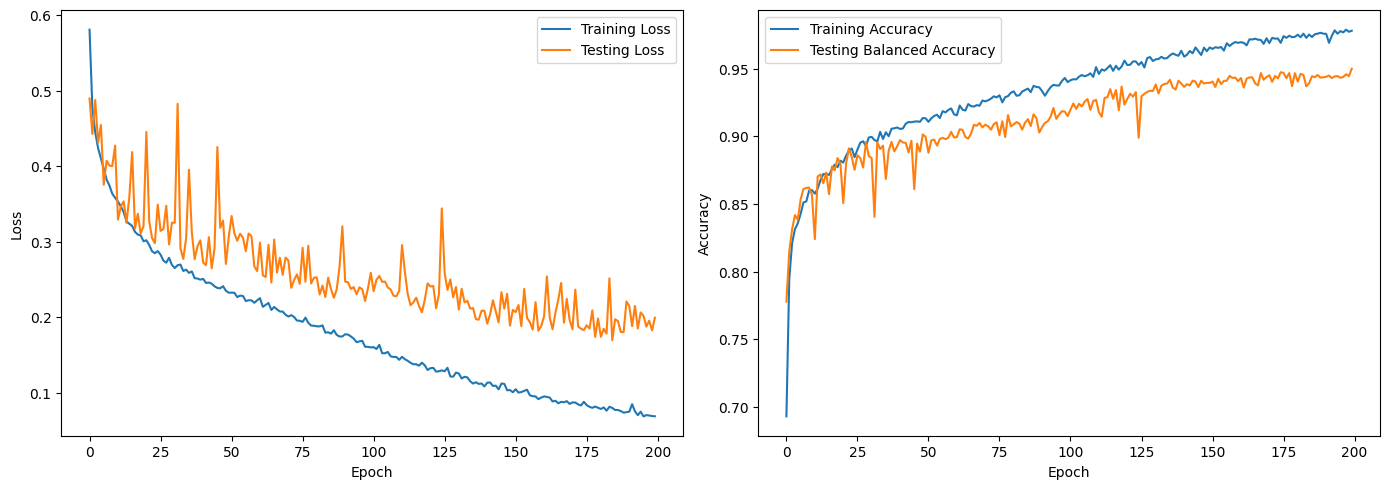

In [30]:
train_model(cnn, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=False)
plot_acc_and_loss(model_name, num_epochs)

In [31]:
cnn.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(cnn, criterion, X_test_tensor, y_test_tensor)

CNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=5984, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 7617
Accuracy: 0.9436, Loss: 0.1996, Balanced Accuracy: 0.9499421814208062


### CNN with residual connections

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        x = self.relu(x)
        return x

In [33]:
class ResidualCNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.residual_block1 = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2 = ResidualBlock(16, 16, 3, 1, 1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32*input_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.squeeze(x, dim=-1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [34]:
input_size = X_train_tensor.shape[1]
output_size = 1

cnn_res = ResidualCNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_res.parameters(), lr=0.001)

In [35]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'cnn_res'

Epoch [200/200], Training Loss: 0.0320, Training Accuracy: 0.9870, Test loss: 0.3754, Test Accuracy: 0.9487: 100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


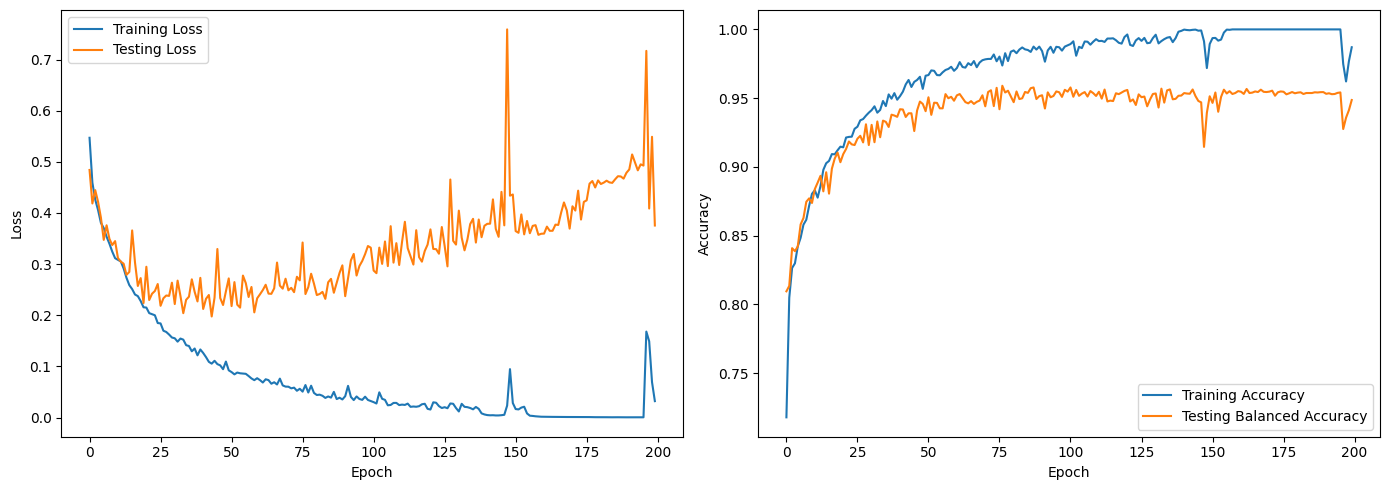

In [36]:
train_model(cnn_res, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=False)
plot_acc_and_loss(model_name, num_epochs)

In [33]:
cnn_res.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(cnn_res, criterion, X_test_tensor, y_test_tensor)

NameError: name 'cnn_res' is not defined

## Attention and Transformers

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(5000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [29]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_size, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding_fc1 = nn.Linear(input_dim, d_model)
        self.embedding_fc2 = nn.Linear(d_model, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first = True, norm_first=False, activation="relu")
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.sigmoid = nn.Sigmoid()
        self.d_model = d_model

    def embed(self, src):
        src = self.embedding_fc2(nn.functional.relu(self.embedding_fc1(src))) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        return src
        
    def forward(self, src):
        src = self.embed(src)
        output = self.transformer_encoder(src)
        output = self.fc(output.mean(dim=1))  # Global average pooling
        output = self.sigmoid(output)
        
        attention_weights = self.transformer_encoder.layers[0].self_attn.in_proj_weight
        first_layer_weights = self.embedding_fc1.weight
        
        return output, (attention_weights, first_layer_weights)

In [30]:
input_size = X_train_tensor.shape[2]
output_size = 1

transformer = TransformerModel(input_size, output_size, d_model=16).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

In [31]:
num_epochs = 100
torch.manual_seed(42)
model_name = 'transformer'

Epoch [100/100], Loss: 0.2860, Balanced Accuracy: 0.8699, Test Loss: 0.2979, Test Balanced Accuracy: 0.8753: 100%|██████████| 100/100 [10:06<00:00,  6.07s/it]


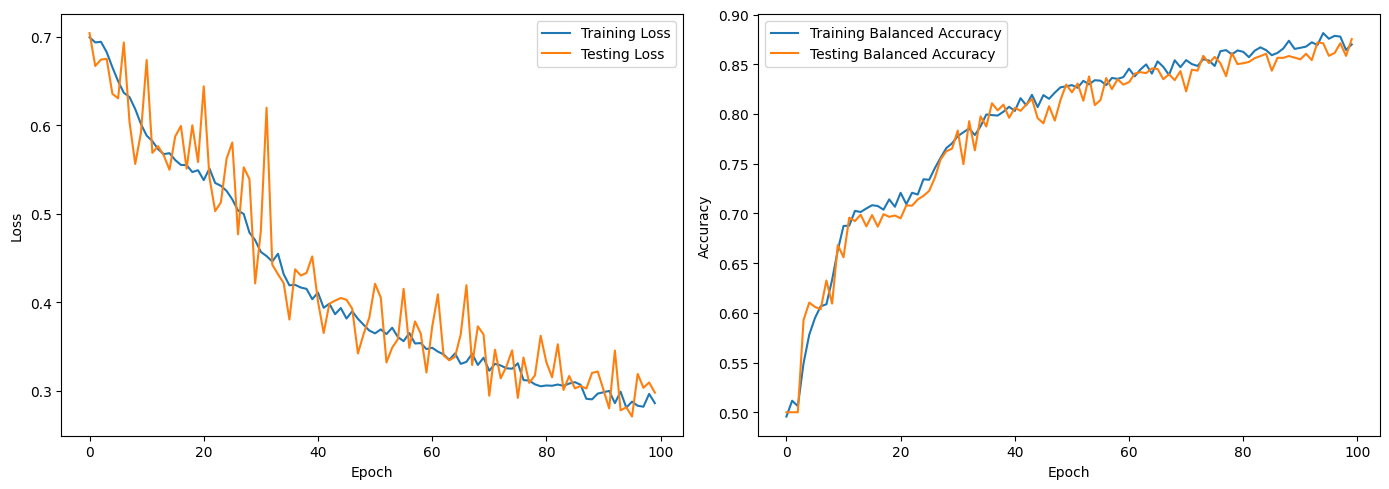

In [32]:
train_model(transformer, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=False, ret_weights=True)
plot_acc_and_loss(model_name, num_epochs)

In [23]:
transformer.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(transformer, criterion, X_test_tensor, y_test_tensor, ret_weights=True)

TransformerModel(
  (embedding_fc1): Linear(in_features=1, out_features=16, bias=True)
  (embedding_fc2): Linear(in_features=16, out_features=16, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=16, out_features=1,

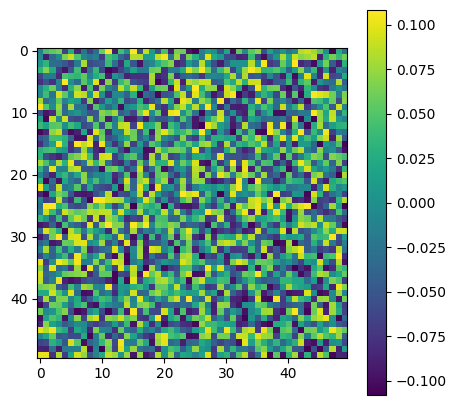

In [17]:
# Set the model to evaluation mode
transformer.eval()

# Pass the input data through the model to get the output and attention weights
output, (attention_weights, first_layer_weights) = transformer(X_test_tensor[0,:,:].unsqueeze(0))

plt.figure(figsize=(5,5))
plt.imshow(attention_weights.detach().cpu().numpy()[:50,:50])
plt.colorbar()
plt.show()

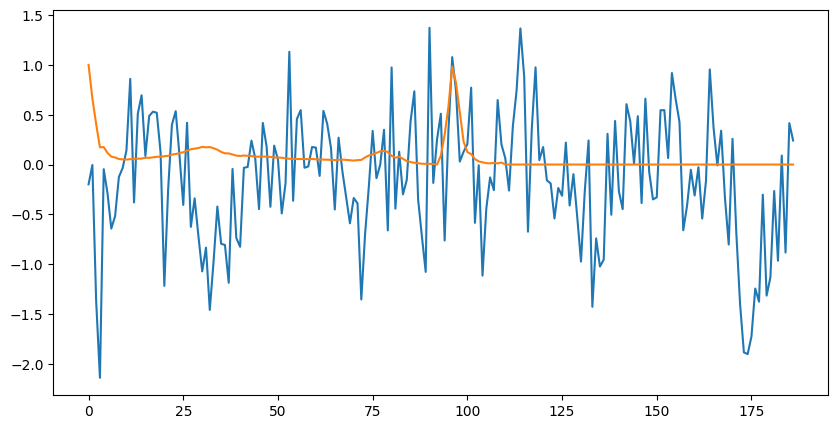

In [18]:
plt.figure(figsize=(10,5))
plt.plot(first_layer_weights.detach().cpu().numpy().sum(axis=0))
plt.plot(X_test_tensor[0,:,:].detach().cpu().numpy())
plt.show()

In [40]:
def compute_selfattention(transformer_encoder, x, i_layer, d_model, num_heads):
    h = torch.nn.functional.linear(x, transformer_encoder.layers[i_layer].self_attn.in_proj_weight, bias=transformer_encoder.layers[i_layer].self_attn.in_proj_bias)
    qkv = h.reshape(x.shape[0], x.shape[1], num_heads, 3 * d_model//num_heads)
    qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
    q, k, v = qkv.chunk(3, dim=-1) # [Batch, Head, SeqLen, d_head=d_model//num_heads]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [Batch, Head, SeqLen, SeqLen]
    d_k = q.size()[-1]
    attn_probs = attn_logits / math.sqrt(d_k)
    
    attn_probs = torch.nn.functional.softmax(attn_probs, dim=-1)
    return attn_logits,attn_probs

def extract_selfattention_maps(transformer_encoder, x):
    attn_logits_maps = []
    attn_probs_maps = []
    num_layers = transformer_encoder.num_layers
    d_model = transformer_encoder.layers[0].self_attn.embed_dim
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            # attn = transformer_encoder.layers[i].self_attn(h, h, h,attn_mask=mask,key_padding_mask=src_key_padding_mask,need_weights=True)[1]
            # attention_maps.append(attn) # of shape [batch_size,seq_len,seq_len]
            attn_logits,attn_probs = compute_selfattention(transformer_encoder,h,i,d_model,num_heads)
            attn_logits_maps.append(attn_logits) # of shape [batch_size,num_heads,seq_len,seq_len]
            attn_probs_maps.append(attn_probs)
            # forward of layer i
            x = transformer_encoder.layers[i](x,src_mask=None,src_key_padding_mask=None)
    return attn_logits_maps,attn_probs_maps

In [41]:
self_attention_maps_logits, self_attention_maps_probs = extract_selfattention_maps(transformer.transformer_encoder, transformer.embed(X_train_tensor[0,:,:].unsqueeze(0)))

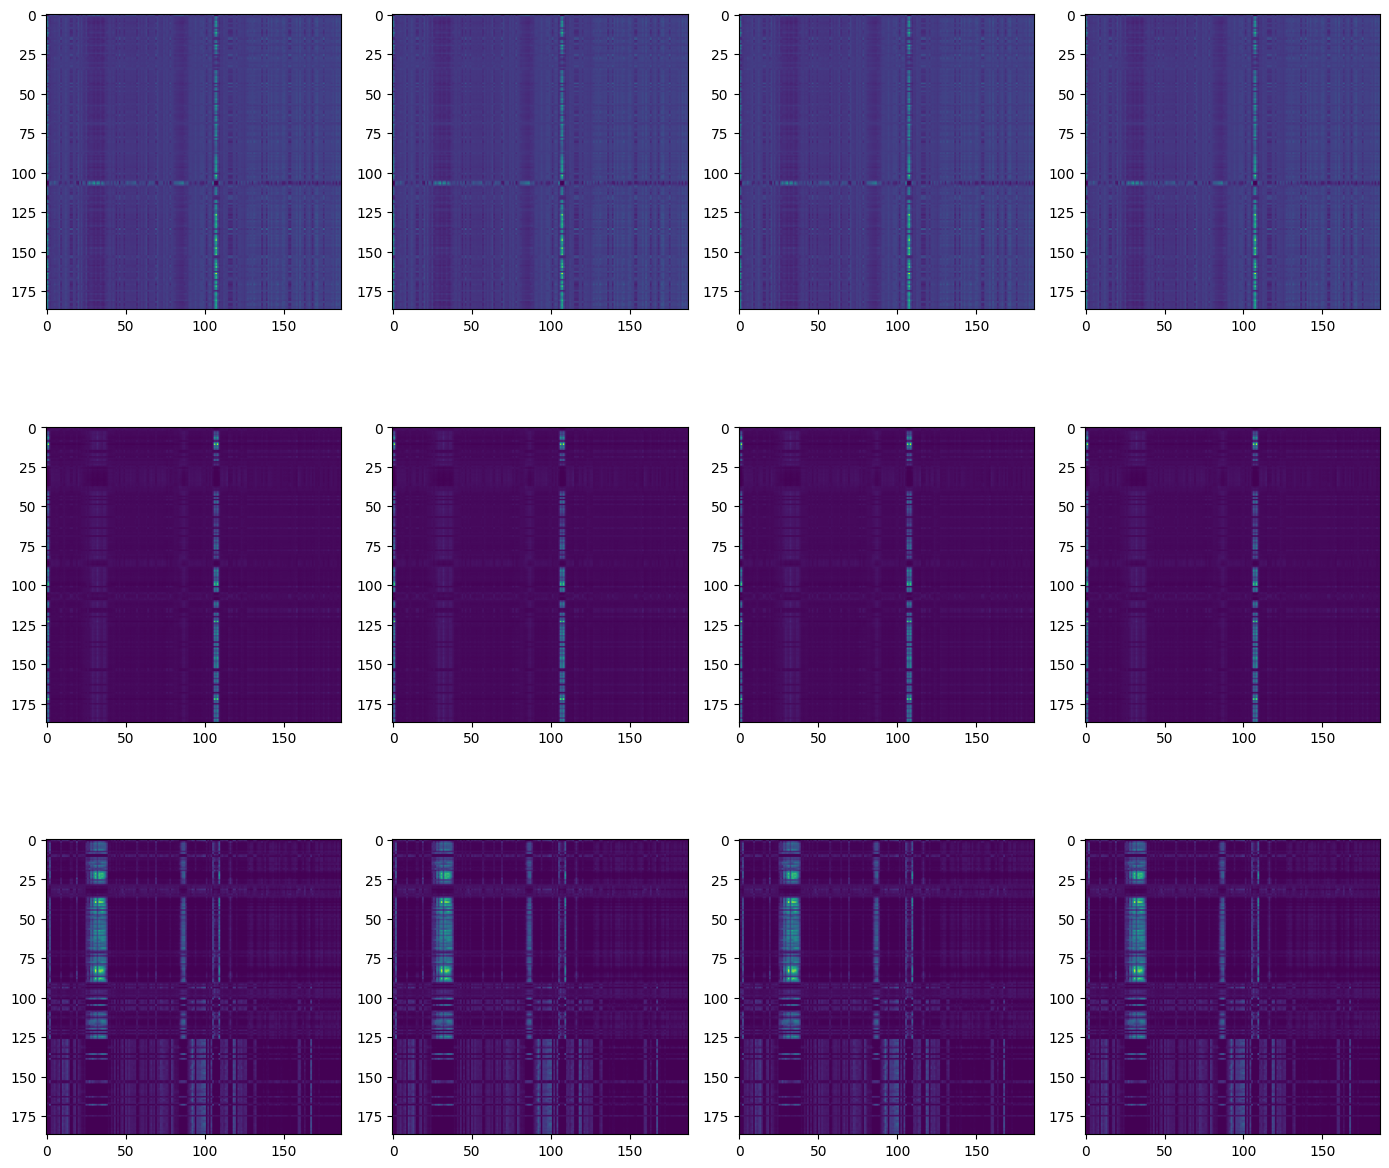

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(14, 14))

    # # Plotting the losses
    # axs[0].plot(epoch_losses_training, label='Training Loss')
    # axs[0].plot(epoch_losses_testing, label='Testing Loss')
    # axs[0].set_xlabel('Epoch')
    # axs[0].set_ylabel('Loss')
    # axs[0].legend()
for i, map in enumerate(self_attention_maps_probs):
    for j in range(4):
        axs[i,j].imshow(map[0,i,:,:].detach().cpu().numpy())
    
    plt.tight_layout()
